In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import tensorflow as tf
import sonnet as snt

import numpy as np
from bnn.model_utils import *
import matplotlib.pyplot as plt
from cycler import cycler
from bnn.BNN_MLP import *
from copy import deepcopy

In [11]:
def permute(task, seed):
    np.random.seed(seed)
    perm = np.random.permutation(task.train._images.shape[1])
    permuted = deepcopy(task)
    permuted.train._images = permuted.train._images[:, perm]
    permuted.test._images = permuted.test._images[:, perm]
    permuted.validation._images = permuted.validation._images[:, perm]
    return permuted

def make_tf_data_batch(x, y, shuffle=True):
    # create Dataset objects using the data previously downloaded
    dataset_train = tf.data.Dataset.from_tensor_slices((x, y.astype(np.int32)))

    if shuffle:
        dataset_train = dataset_train.shuffle(100000)

    # we shuffle the data and sample repeatedly batches for training
    batched_dataset_train = dataset_train.repeat().batch(BATCH_SIZE)
    # create iterator to retrieve batches
    iterator_train = batched_dataset_train.make_one_shot_iterator()
    # get a training batch of images and labels
    (batch_train_images, batch_train_labels) = iterator_train.get_next()

    return batch_train_images, batch_train_labels

def get_training_params(train_set,train_label,test_set,test_label):
    out, log_probs, nll = net(train_set, targets=train_label, sample=True, n_samples=1, 
                              loss_function=lambda y, y_target: tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_target, logits=y))

    num_batches = (len(mnist.train.labels)//BATCH_SIZE)
    loss = 0.01*log_probs/num_batches + nll
    optim = tf.train.AdamOptimizer(learning_rate=0.001)
    train_op = optim.minimize( loss )

    out_test_deterministic, _, _ = net(test_set, sample=False, loss_function=None)
    prediction = tf.cast(tf.argmax(out_test_deterministic, 1), tf.int32)
    equality = tf.equal(prediction, test_label)
    accuracy = tf.reduce_mean(tf.cast(equality, tf.float32))
    
    return train_op, loss,accuracy


In [12]:
def train(net,loss,train_op,accuracy,loss2=None,accuracy2=None):
    for i in range(TRAINING_STEPS):
        l, _ = sess.run([loss, train_op])
        l2 = None
        if loss2 is not None:
            l2 = sess.run([loss2])
        if i>=1000 and i%1000==0:
            # Test accuracy
            avg_acc = 0.0
            avg_acc2 = 0.0
            num_iters = len(mnist.test.labels)//BATCH_SIZE
            for test_iter in range(num_iters):
                acc = sess.run(accuracy)
                avg_acc += acc
                if accuracy2 is not None:
                    acc2 = sess.run(accuracy2)
                    avg_acc2 += acc2

            avg_acc /= num_iters
            avg_acc2 /= num_iters
            print("Iteration ", i, "loss: ", l, "accuracy: ", avg_acc, "loss2: ", l2,"accuracy2: ", avg_acc2)
            

            ## Histogram of standard deviations (w and b)
            all_stds = []
            for l in net.layers:
                w_sigma = np.reshape( sess.run(l.w_sigma), [-1] ).tolist()
                b_sigma = np.reshape( sess.run(l.b_sigma), [-1] ).tolist()
                all_stds += w_sigma + b_sigma

            n = TRAINING_STEPS//1000
            plt.rc('axes', prop_cycle=cycler('color', [plt.get_cmap('inferno')(1. * float(i)/n) for i in range(n)]))
            lbl = ""
            if i==1000:
                lbl = "t=1000"
            elif i==1000*(TRAINING_STEPS//1000):
                lbl = "t="+str(1000*(TRAINING_STEPS//1000))
            plt.hist(all_stds, 100, alpha=0.3, label=lbl)

In [13]:
def test(net,loss,accuracy,loss2,accuracy2):
    for i in range(10):
        l, l2 = sess.run([loss, loss2])
        
        # Test accuracy
        avg_acc = 0.0
        avg_acc2 = 0.0
        num_iters = len(mnist.test.labels)//BATCH_SIZE
        for test_iter in range(num_iters):
            acc = sess.run(accuracy)
            avg_acc += acc

            acc2 = sess.run(accuracy2)
            avg_acc2 += acc2

        avg_acc /= num_iters
        avg_acc2 /= num_iters
        print("Iteration ", i, "loss: ", l, "accuracy: ", avg_acc, "loss2: ", l2,"accuracy2: ", avg_acc2)



In [14]:
BATCH_SIZE = 64
TRAINING_STEPS = 2001

In [15]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
mnist2 = permute(mnist,0)

#train_x, train_y = make_tf_data_batch(mnist.train.images, mnist.train.labels)
#test_x, test_y = make_tf_data_batch(mnist.test.images, mnist.test.labels, shuffle=False)
#train_x2, train_y2 = make_tf_data_batch(mnist2.train.images, mnist2.train.labels)
#test_x2, test_y2 = make_tf_data_batch(mnist2.test.images, mnist2.test.labels, shuffle=False)

train_x, train_y = make_tf_data_batch(mnist.train.images[mnist.train.labels<5], mnist.train.labels[mnist.train.labels<5])
test_x, test_y = make_tf_data_batch(mnist.test.images[mnist.test.labels<5], mnist.test.labels[mnist.test.labels<5], shuffle=False)
train_x2, train_y2 = make_tf_data_batch(mnist.train.images[mnist.train.labels>4], mnist.train.labels[mnist.train.labels>4])
test_x2, test_y2 = make_tf_data_batch(mnist.test.images[mnist.test.labels>4], mnist.test.labels[mnist.test.labels>4], shuffle=False)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [16]:
net = BNN_MLP(n_inputs=784, n_outputs=10, hidden_units=[200, 200], init_mu=0.0, init_rho=-3.0, 
              activation=tf.nn.relu, last_activation=tf.identity)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
train_op_1, loss_1, accuracy_1 = get_training_params(train_x,train_y,test_x,test_y)
train_op_2, loss_2, accuracy_2 = get_training_params(train_x2,train_y2,test_x2,test_y2)

In [ ]:
sess = tf.InteractiveSession()
sess.run( tf.global_variables_initializer() )

Iteration  1000 loss:  None accuracy:  0.9790665064102564 loss2:  None accuracy2:  0.0
Iteration  2000 loss:  None accuracy:  0.9825721153846154 loss2:  None accuracy2:  0.0


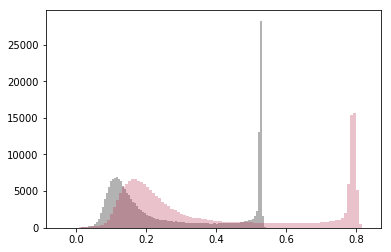

In [11]:
train(net,train_op_1, loss_1, accuracy_1)

In [12]:
params1 = save_model_params(net,sess)

Iteration  1000 loss:  None accuracy:  0.9155649038461539 loss2:  [nan] accuracy2:  0.0
Iteration  2000 loss:  None accuracy:  0.9545272435897436 loss2:  [nan] accuracy2:  0.0


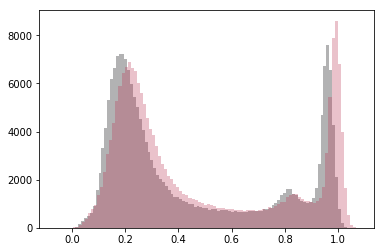

In [13]:
train(net,train_op_2,loss_1,accuracy_1, loss_2, accuracy_2)

In [14]:
params2 = save_model_params(net,sess)

In [15]:
set_new_params(net,params1,params2,sess)

<tf.Variable 'Variable:0' shape=(784, 200) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(784, 200) dtype=float32_ref>
<tf.Variable 'Variable_2:0' shape=(200,) dtype=float32_ref>
<tf.Variable 'Variable_3:0' shape=(200,) dtype=float32_ref>
<tf.Variable 'Variable_4:0' shape=(200, 200) dtype=float32_ref>
<tf.Variable 'Variable_5:0' shape=(200, 200) dtype=float32_ref>
<tf.Variable 'Variable_6:0' shape=(200,) dtype=float32_ref>
<tf.Variable 'Variable_7:0' shape=(200,) dtype=float32_ref>
<tf.Variable 'Variable_8:0' shape=(200, 10) dtype=float32_ref>
<tf.Variable 'Variable_9:0' shape=(200, 10) dtype=float32_ref>
<tf.Variable 'Variable_10:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'Variable_11:0' shape=(10,) dtype=float32_ref>


In [18]:
test(net,loss_1,accuracy_1,loss_2,accuracy_2)

Iteration  0 loss:  nan accuracy:  0.6039663461538461 loss2:  nan accuracy2:  0.897636217948718
Iteration  1 loss:  nan accuracy:  0.6041666666666666 loss2:  nan accuracy2:  0.8983373397435898
Iteration  2 loss:  nan accuracy:  0.6039663461538461 loss2:  nan accuracy2:  0.8981370192307693
Iteration  3 loss:  nan accuracy:  0.6031650641025641 loss2:  nan accuracy2:  0.8977363782051282
Iteration  4 loss:  nan accuracy:  0.6018629807692307 loss2:  nan accuracy2:  0.8981370192307693
Iteration  5 loss:  nan accuracy:  0.6002604166666666 loss2:  nan accuracy2:  0.8975360576923077
Iteration  6 loss:  nan accuracy:  0.6020633012820513 loss2:  nan accuracy2:  0.8971354166666666
Iteration  7 loss:  nan accuracy:  0.604667467948718 loss2:  nan accuracy2:  0.8959334935897436
Iteration  8 loss:  nan accuracy:  0.6043669871794872 loss2:  nan accuracy2:  0.8940304487179487
Iteration  9 loss:  nan accuracy:  0.6031650641025641 loss2:  nan accuracy2:  0.8949318910256411
